In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [3]:
from src.functional import smpl
from src.functional.optical_flow import unproject_optical_flows_to_vertices
from src.functional.renderer import get_default_cameras
from src.models import raft
from src.datasets.datasets_common import UNNORMALIZE

device = "cuda:0" #trainer.device0

### init smpl
smpl_model_14 = smpl.get_smpl_model("h36m", device=device)
smpl_model_49 = smpl.get_smpl_model("extra", device=device)
smpl_model_faces = smpl_model_49.faces.astype(int)

# this renaming allows to run eval on 3dpw without any changes
smpl_model = smpl_model_14

### set faces for renderer
smpl_model_faces = smpl_model_49.faces.astype(int)
faces = smpl_model_49.faces.astype(int)
smpl_model_faces = torch.tensor(smpl_model_faces.copy()).unsqueeze(0)

### init cameras
cameras = get_default_cameras(device, mode="orthographic")

### init optical flow model
optical_flow_model = raft.raft_pretrained().to(device)
optical_flow_model.eval();

In [4]:
from src.procedures.procedures.finetune_hmr_ssl import compute_optical_flows
from src.datasets.threedpw import ThreeDPW
from src.functional.optical_flow import unproject_optical_flows_to_vertices
from src.datasets.datasets_common import UNNORMALIZE
from src.utils.vis_utils import render_mesh_onto_image
from src.utils import img_utils, vis_utils, video_utils

from src.functional.renderer import (
    convert_vertices_to_mesh,
    fit_vertices_to_orthographic,
    get_vertex_visibility_mask,
    unproject_to_vertices,
)

In [5]:
def custom_test_verts_rendered(img, verts, faces, device, do_z_scaling=True):
    
    frame_ids = [0, 25, 50, 75, 99]
    video = UNNORMALIZE(img).permute(0,2,3,1)
    fig, ax = plt.subplots(1, len(frame_ids), figsize=(len(frame_ids) * 4, 4))

    for i, (frame_idx, axis) in enumerate(zip(frame_ids, ax.flatten())):
        img_ = video[frame_idx].numpy()
        verts_ = verts[frame_idx].copy()
        
        if do_z_scaling:
            verts_[:, 2] *= 100
            
        blend_img = vis_utils.render_mesh_onto_image(img_, verts_, faces, device=device)
        axis.imshow(blend_img)
        axis.set_axis_off()

    fig.tight_layout()
    fig.patch.set_facecolor("black")

### test 3DPW

### goal is to compute per-vertex 2D displacements from OF and HMR and w.r.t the GT 

1. from optical flow model
2. from GT
3. from HMR

Pipeline in this case:
* video -> HMR predictions -> body on the image, mask of visible vertices
* video -> OF video
* using mask, extract vertices, assign OF values to the vertices (as it is currently done in `finetune` pipeline)


In [6]:
img = torch.load("./../output/test_OF_quality/img.pth")
print(img.shape)
batch_size = img.size(0)
img_size = img.size(-1)

torch.Size([128, 3, 224, 224])


In [7]:
# ### load hmrnet
# from src.models.hmr import hmr
# hmrnet = hmr(pretrained=True)

# ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"
# ckpt = torch.load(ckpt, map_location=device)
# hmrnet.load_state_dict(ckpt["hmrnet_state_dict"])
# hmrnet = hmrnet.to(device)

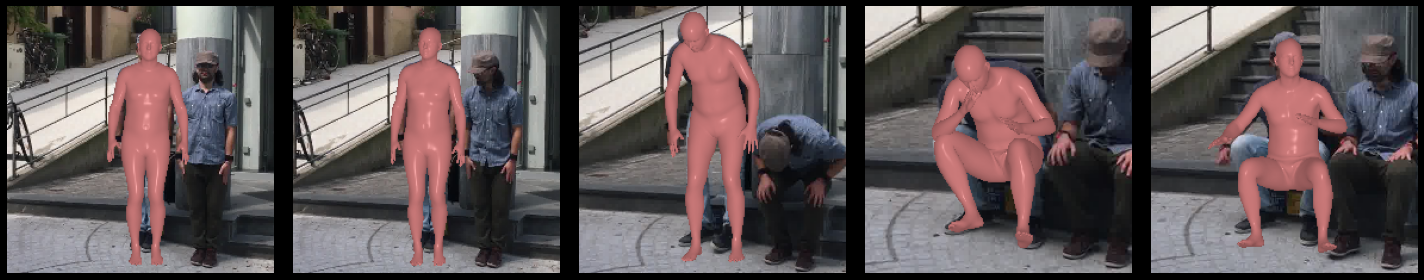

In [8]:
# with torch.no_grad():

#     ### STEP 1.
#     ### compute HMR predictions
#     pred_smpl_rotmat, pred_smpl_shape, pred_camera = hmrnet(img.to(device))
#     pred_out = smpl_model_49(
#         betas=pred_smpl_shape,
#         body_pose=pred_smpl_rotmat[:, 1:],
#         global_orient=pred_smpl_rotmat[:, :1],
#         pose2rot=False,
#     )
#     j3d = pred_out.joints
#     verts3d = pred_out.vertices

#     ### align vertices with pixels
#     scale, trans = pred_camera[:, 0], pred_camera[:, 1:]
#     verts3d = verts3d * scale.view(verts3d.size(0), 1, 1)
#     verts3d[:, :, 0:2] = verts3d[:, :, 0:2] + trans.view(verts3d.size(0), 1, 2)
#     verts3d = (verts3d + 1) / 2 * img_size

#     verts3d_pred = verts3d.clone()
#     print(verts3d_pred.shape)

verts3d_pred = torch.load("./../output/test_OF_quality/verts_aligned_HMR.pth", map_location='cpu')
custom_test_verts_rendered(img.cpu(), verts3d_pred.cpu().numpy(), faces, device="cpu", do_z_scaling=False)

torch.Size([128, 6890, 3])


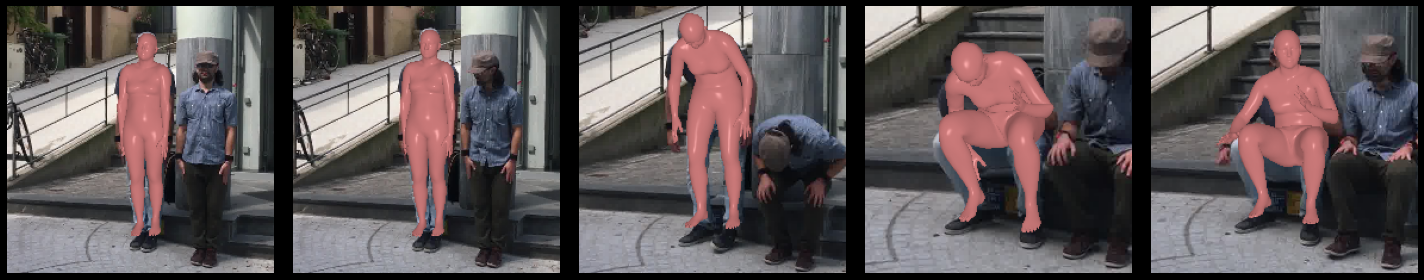

In [9]:
### STEP 2.
### Load GT bodies

verts3d_gt = torch.tensor(torch.load("./../output/test_OF_quality/verts_aligned_GT.pth"))
print(verts3d_gt.shape)

custom_test_verts_rendered(img.cpu(), verts3d_gt.cpu().numpy(), faces, device="cpu", do_z_scaling=True)

In [10]:
# ### map coordinates to NDC format
# img_size = (224, 224)
# batch_size = 128
# faces_batch = smpl_model_faces.repeat(batch_size, 1, 1).to(device)

# ### map Pred
# verts3d_pred_ = fit_vertices_to_orthographic(verts3d_pred.clone(), img_size=img_size)
# meshes_pred = convert_vertices_to_mesh(verts3d_pred_, faces_batch)
# vis_mask_pred = get_vertex_visibility_mask(meshes_pred, cameras, img_size)
# vis_mask_pred = vis_mask_pred.view(batch_size, 6890)
# print(vis_mask_pred.shape, vis_mask_pred.sum())

# ### map GT
# verts3d_gt_ = fit_vertices_to_orthographic(verts3d_gt.clone(), img_size=img_size)
# meshes_gt = convert_vertices_to_mesh(verts3d_gt_.clone(), faces_batch)
# vis_mask_gt = get_vertex_visibility_mask(meshes_gt, cameras, img_size)
# vis_mask_gt = vis_mask_gt.view(batch_size, 6890)
# print(vis_mask_gt.shape, vis_mask_gt.sum())


### result of the code above
vis_mask_gt = torch.load("./../output/test_OF_quality/vis_mask_GT.pth") #.to(device)
vis_mask_pred = torch.load("./../output/test_OF_quality/vis_mask_HMR.pth") #.to(device)
print(vis_mask_gt.shape, vis_mask_gt.shape)

torch.Size([128, 6890]) torch.Size([128, 6890])


In [11]:
def of_run(img1, img2, device, max_batch=32):
    
    if img1.size(0) > max_batch:
        img1 = torch.split(img1, max_batch)
        img2 = torch.split(img2, max_batch)
        of_f, of_b = [], []
        for img1_, img2_ in zip(img1, img2):
            of_f_, of_b_ = of_run(img1_, img2_, device)
            of_f.append(of_f_)
            of_b.append(of_b_)
        of_f = torch.cat(of_f)
        of_b = torch.cat(of_b)
        return of_f, of_b
    
    img1 = img1.to(device)
    img2 = img2.to(device)
    
    with torch.no_grad():
        # compute forward optical flow
        _, of_f = optical_flow_model(img1, img2, iters=20, test_mode=True)
        # compute backward optical flow
        _, of_b = optical_flow_model(img2, img1, iters=20, test_mode=True)
    
    of_f = of_f.cpu()
    of_b = of_b.cpu()
    del img1
    del img2
    torch.cuda.empty_cache()
    
    return of_f, of_b
    

def compute_optical_flows(video, delta, device="cuda:0"):
    '''
    video: tensor, B x 3 x H x W. Tensor of images, unnormalized! Device is CPU.
    delta: int
    '''
    img1 = video[:-delta]
    img2 = video[delta:]
    of_f, of_b = of_run(img1, img2, device)
    return of_f, of_b
    

In [12]:
def unproject_of(of_f, of_b, vis_mask, verts3d, delta):
    #  mask should be the intersection of neighboring masks
    vis_mask_intersection = vis_mask[:-delta] * vis_mask[delta:]  # B-delta x N  (B - # of frames)
    
    verts3d_start = verts3d[:-delta]
    verts3d_end = verts3d[delta:]
    
    ### unproject optical flow to vertices
    #  NOTE: flow values are in pixels!
    unproj_flow2d_forward = unproject_to_vertices(of_f, verts3d_start)
    unproj_flow2d_backward = unproject_to_vertices(of_b, verts3d_end)
    
    return unproj_flow2d_forward, unproj_flow2d_backward, vis_mask_intersection    
    

In [13]:
data = {
    "GT": [verts3d_gt, vis_mask_gt],
    "HMR": [verts3d_pred, vis_mask_pred],
}

In [14]:
video = UNNORMALIZE(img)

d_delta = {}
deltas = [1,2,3,4,5,6,7,8,9,10,11,12]
for delta in tqdm(deltas, desc="cur delta t: "):
    d_flow_loss = {}
    
    ### STEP 3.
    ### compute optical flows for a given delta time
    of_f, of_b = compute_optical_flows(video, delta, device)
    of_f = of_f.to(device)
    of_b = of_b.to(device)  
    
    for signal in ["GT", "HMR"]:
        d_flow_loss[signal] = {}
        
        verts3d, vis_mask = data[signal]

        ### Step 4.
        ### Unproject OF to vertices 
        vis_mask = vis_mask.to(device)
        verts3d = verts3d.to(device)
        unproj_of_f, unproj_of_b, vis_mask_inters = unproject_of(of_f, of_b, vis_mask, verts3d, delta)
    
        ### Step 5.
        ### compute flow from vertices
        verts2d_flow_f = verts3d[delta:, :, :2] - verts3d[:-delta, :, :2]
        verts2d_flow_b = verts3d[:-delta, :, :2] - verts3d[delta:, :, :2]
            
        ### STEP 5. 
        ### compute flow 2d loss averaged by vertices
        flow_loss_f = (verts2d_flow_f - unproj_of_f) ** 2
        flow_loss_f = flow_loss_f.sum(dim=-1)  # B x N
        flow_loss_f = flow_loss_f * vis_mask_inters
        flow_loss_f = flow_loss_f.sum(dim=-1) / vis_mask_inters.sum(dim=-1)
        d_flow_loss[signal]["forward"] = flow_loss_f.cpu()

        flow_loss_b = (verts2d_flow_b - unproj_of_b) ** 2
        flow_loss_b = flow_loss_b.sum(dim=-1)  # B x N
        flow_loss_b = flow_loss_b * vis_mask_inters
        flow_loss_b = flow_loss_b.sum(dim=-1) / vis_mask_inters.sum(dim=-1)
        d_flow_loss[signal]["backward"] = flow_loss_f.cpu()

        torch.cuda.empty_cache()

    d_delta[delta] = d_flow_loss


cur delta t:   0%|                                                                                                                                         | 0/12 [00:00<?, ?it/s]/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643003845/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
cur delta t: 100%|███████████████████████████████████████████████████████████████

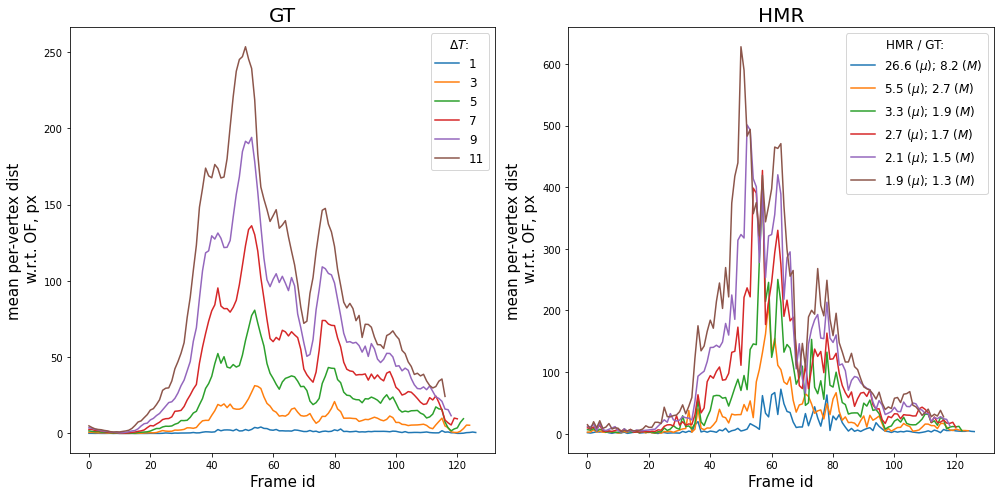

In [70]:
for direction in ["forward", "backward"][:1]:
    
    fig, ax = plt.subplots(1,2, figsize=(14,7))
    for delta in deltas[::2]:
        loss_gt = d_delta[delta]["GT"][direction]
        loss_hmr = d_delta[delta]["HMR"][direction]
        ax[0].plot(loss_gt, label=f"{delta}")
        ax[1].plot(loss_hmr, label=f"{(loss_hmr/loss_gt).mean():.1f} ($\mu$); {(loss_hmr/loss_gt).median():.1f} ($M$)")

        ax[0].set_title("GT", fontsize=20)
        ax[1].set_title("HMR", fontsize=20)
        for axis in ax:
            axis.set_xlabel("Frame id", fontsize=15)
            axis.set_ylabel("mean per-vertex dist\n w.r.t. OF, px", fontsize=15)
            
        ax[0].legend(fontsize=12, title="$\Delta T$: ", title_fontsize=12)
        ax[1].legend(fontsize=12, title="HMR / GT: ", title_fontsize=12)

    fig.tight_layout()
    fig.patch.set_facecolor("white")

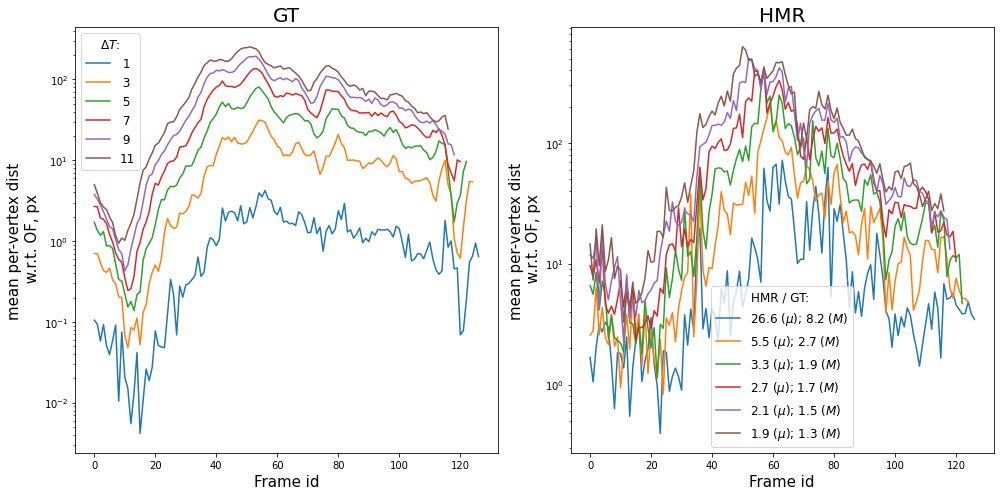

In [72]:
for direction in ["forward", "backward"][:1]:
    
    fig, ax = plt.subplots(1,2, figsize=(14,7))
    for delta in deltas[::2]:
        loss_gt = d_delta[delta]["GT"][direction]
        loss_hmr = d_delta[delta]["HMR"][direction]
        ax[0].semilogy(loss_gt, label=f"{delta:2}")
        ax[1].semilogy(loss_hmr, label=f"{(loss_hmr/loss_gt).mean():.1f} ($\mu$); {(loss_hmr/loss_gt).median():.1f} ($M$)")

        ax[0].set_title("GT", fontsize=20)
        ax[1].set_title("HMR", fontsize=20)
        for axis in ax:
            axis.set_xlabel("Frame id", fontsize=15)
            axis.set_ylabel("mean per-vertex dist\n w.r.t. OF, px", fontsize=15)
            
        ax[0].legend(fontsize=12, title="$\Delta T$: ", title_fontsize=12)
        ax[1].legend(fontsize=12, title="HMR / GT: ", title_fontsize=12)

    fig.tight_layout()
    fig.patch.set_facecolor("white")